In [1]:
%load_ext autoreload
%autoreload 2

import time
import pickle
import numpy as np
from scipy import optimize

import matplotlib.pyplot as plt   
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

from HancModel import HANCModelClass

In [2]:
model = HANCModelClass(name='baseline') # create an instance of the model

In [3]:
model.info()

settings:
 par.py_hh = False
 par.py_block = True
 par.full_z_trans = False
 par.T = 500

households:
 grids_hh: [a]
 pols_hh: [a]
 inputs_hh: [r,w_low,w_high,phi_low,phi_high]
 inputs_hh_z: []
 outputs_hh: [a,c]
 intertemps_hh: [vbeg_a]

aggregate:
 shocks: [Gamma,phi_low,phi_high]
 unknowns: [K,L_low,L_high]
 targets: [clearing_A,clearing_L_low,clearing_L_high]

blocks (inputs -> outputs):
 production_firm: [Gamma,K,L_low,L_high,phi_low,phi_high] -> [rK,w_low,w_high,Y]
 mutual_fund: [K,rK] -> [A,r]
 hh: [phi_high,phi_low,r,w_high,w_low] -> [A_hh,C_hh]
 market_clearing: [A,A_hh,L_low,L_high,Y,C_hh,K] -> [L_hh_high,L_hh_low,I,clearing_A,clearing_L_low,clearing_L_high,clearing_Y]


production_firm: [Gamma,K,L_low,L_high,phi_low,phi_high] -> [rK,w_low,w_high,Y]
mutual_fund: [K,rK] -> [A,r]
hh: [phi_high,phi_low,r,w_high,w_low] -> [A_hh,C_hh]
market_clearing: [A,A_hh,L_low,L_high,Y,C_hh,K] -> [L_hh_high,L_hh_low,I,clearing_A,clearing_L_low,clearing_L_high,clearing_Y]


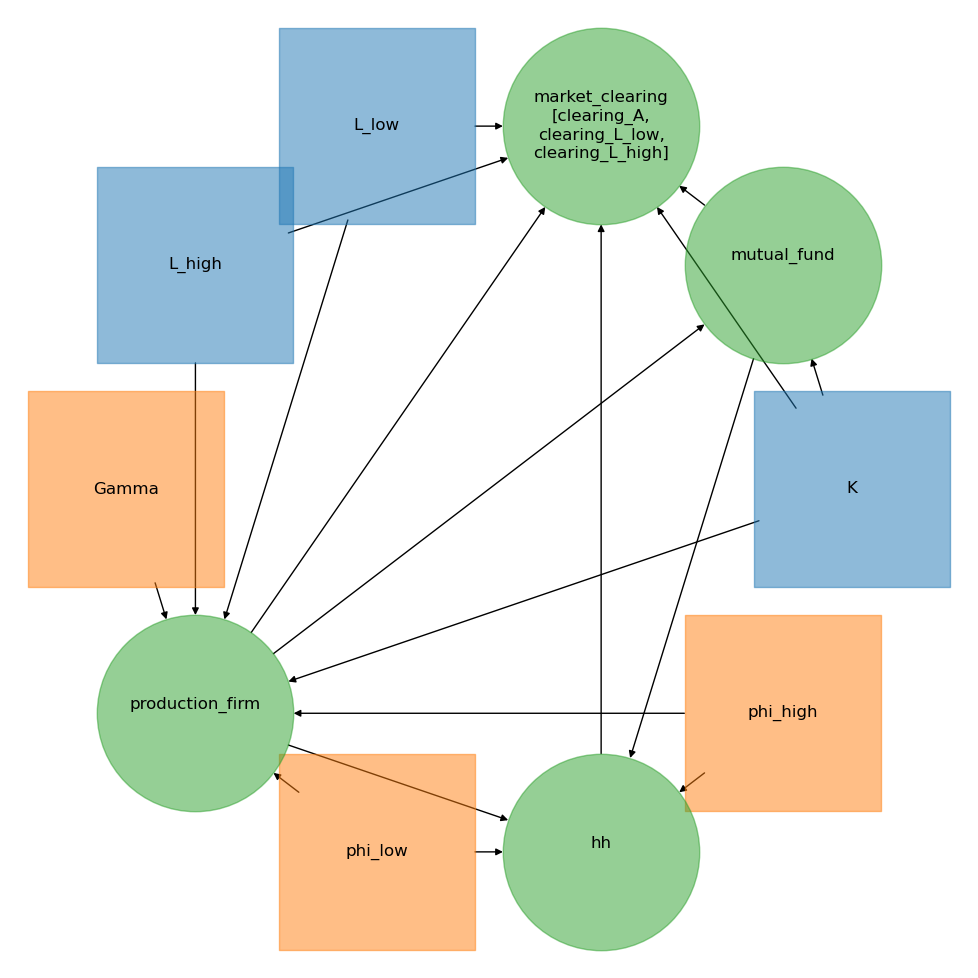

In [4]:
model.info(only_blocks=True)
model.draw_DAG(figsize=(10,10))

In [5]:
par = model.par
ss = model.ss
path = model.path
sim = model.sim

In [6]:
# Calibration parameters
ss.phi_high = 2.0
ss.phi_low = 1.0
# Some guesses for the steady state
ss.r = 0.05
ss.w_high = 1.5
ss.w_low = 1.0
ss.L_high = 1.0
ss.L_low = 0.5

In [7]:
model.solve_hh_ss(do_print=True)
model.simulate_hh_ss(do_print=True)

household problem in ss solved in 5.8 secs [137 iterations]
household problem in ss simulated in 4.9 secs [86 iterations]


In [8]:
model.find_ss(do_print=True)

### step 1: broad search ###

guess ss.K = 0.1000
implied ss.r = 1.1123
implied ss.w_low = 0.1616
implied ss.w_high = 0.1616
solve_hh_ss(), too many iterations
clearing_A =          nan

guess ss.K = 0.6211
implied ss.r = 0.2767
implied ss.w_low = 0.3119
implied ss.w_high = 0.3119
household problem in ss solved in 0.3 secs [332 iterations]
household problem in ss simulated in 0.0 secs [105 iterations]
implied ss.A_hh = 535.7397
clearing_A = -535.11867403

guess ss.K = 1.1421
implied ss.r = 0.1551
implied ss.w_low = 0.3884
implied ss.w_high = 0.3884
household problem in ss solved in 0.7 secs [794 iterations]
household problem in ss simulated in 0.3 secs [867 iterations]
implied ss.A_hh = 507.2614
clearing_A = -506.11930863

guess ss.K = 1.6632
implied ss.r = 0.1005
implied ss.w_low = 0.4447
implied ss.w_high = 0.4447
household problem in ss solved in 1.2 secs [688 iterations]
household problem in ss simulated in 0.1 secs [467 iterations]
implied ss.A_hh = 0.3748
clearing_A =   1.2883216

note: inputs = steady state value -> expected: constant value (straigt line)

household problem solved along transition path in 1.6 secs
household problem simulated along transition in 1.9 secs



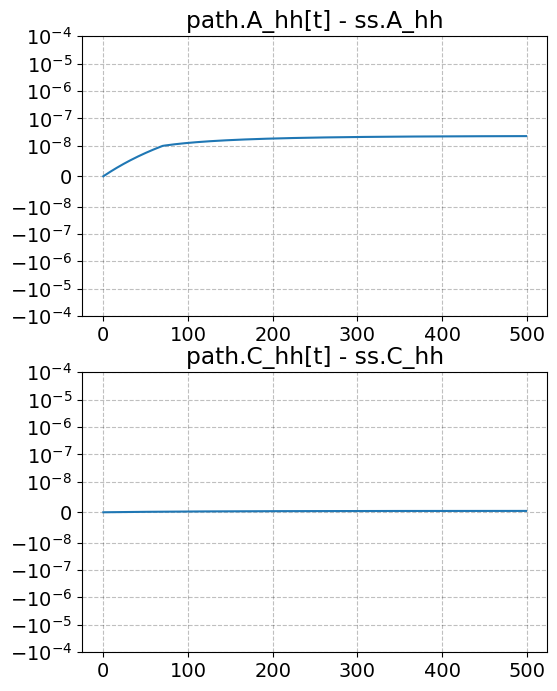

In [9]:
model.test_hh_path()

note: differences should only be due to numerical errors

direct method:
finding Jacobian wrt. ghost          : 0 125 250 375 [computed in 2.8 secs]
finding Jacobian wrt. phi_high       : 0 125 250 375 [computed in 3.2 secs]
finding Jacobian wrt. phi_low        : 0 125 250 375 [computed in 2.4 secs]
finding Jacobian wrt. r              : 0 125 250 375 [computed in 2.9 secs]
finding Jacobian wrt. w_high         : 0 125 250 375 [computed in 3.1 secs]
finding Jacobian wrt. w_low          : 0 125 250 375 [computed in 2.7 secs]
household Jacobian computed in 17.3 secs

fake news method:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for phi_high        in 0.9 secs
curly_Y and curly_D calculated for phi_low         in 1.0 secs
curly_Y and curly_D calculated for r               in 0.9 secs
curly_Y and curly_D calculated for w_high          in 0.9 secs
curly_Y and curly_D calculated for w_low           in 0.9 secs
curly_E calculated in 2.6 secs
buili

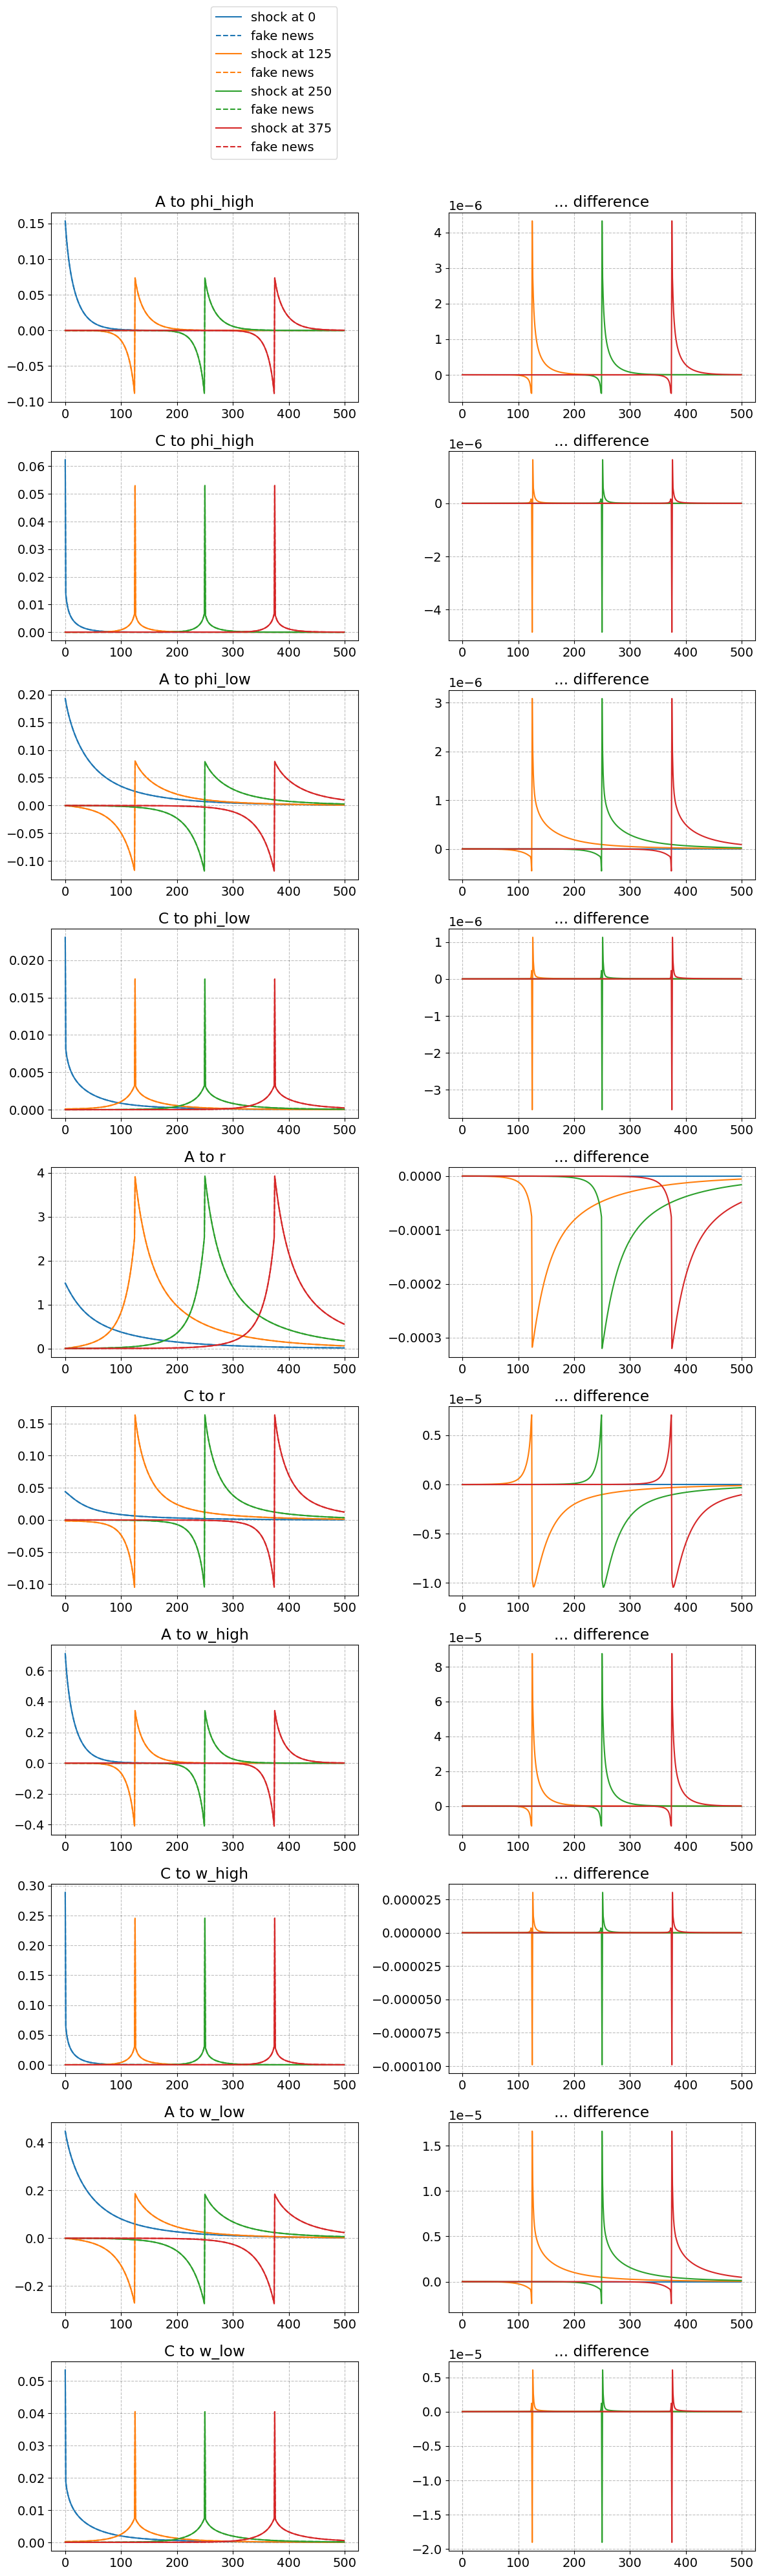

In [10]:
model.test_jacs()

In [11]:
model.compute_jacs(do_print=True)

household Jacobians:
one step deviation from steady state calculated in 0.0 secs
curly_Y and curly_D calculated for phi_high        in 1.4 secs
curly_Y and curly_D calculated for phi_low         in 1.6 secs
curly_Y and curly_D calculated for r               in 2.1 secs
curly_Y and curly_D calculated for w_high          in 2.4 secs
curly_Y and curly_D calculated for w_low           in 2.1 secs
curly_E calculated in 0.5 secs
builiding blocks combined in 1.2 secs
household Jacobian computed in 11.5 secs

full Jacobians:
full Jacobian to unknowns computed in 1.9 secs [in evaluate_blocks(): 0.8 secs]
full Jacobian to shocks computed in 1.4 secs [in evaluate_blocks(): 0.6 secs]


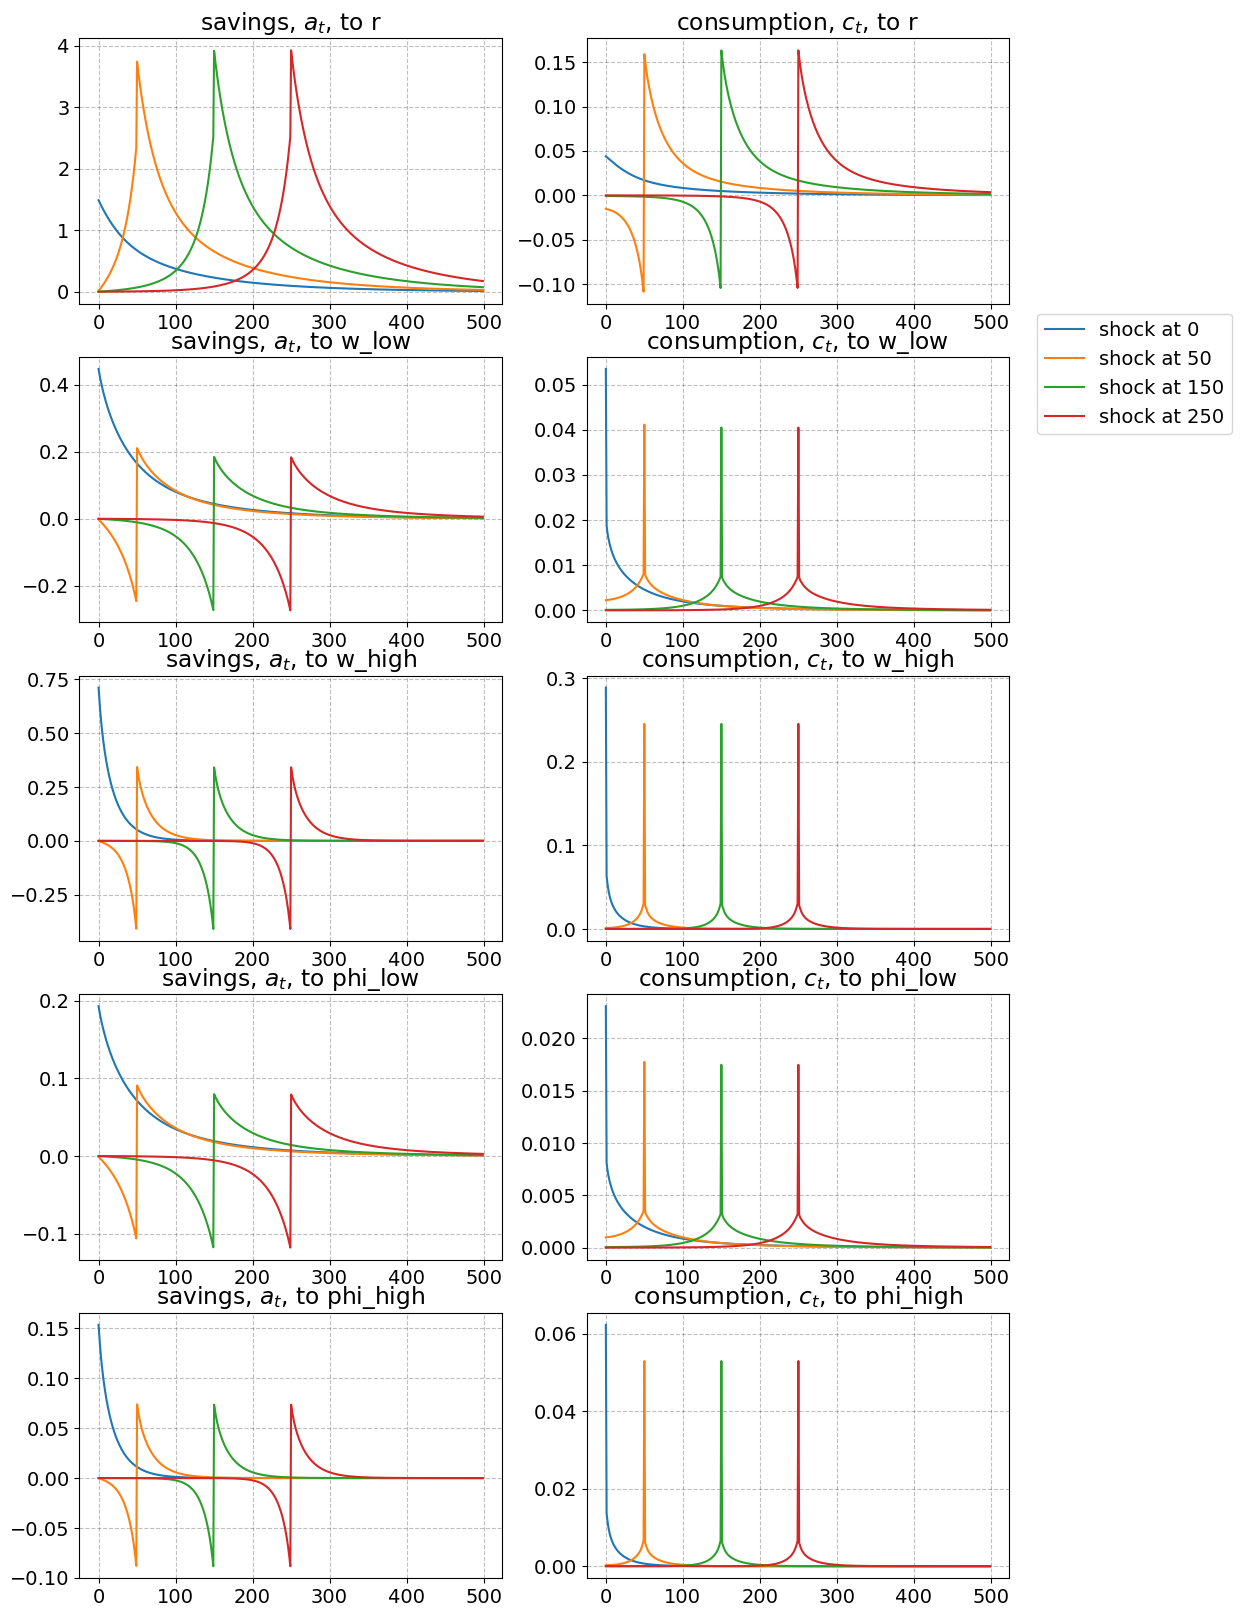

In [12]:
fig = plt.figure(figsize=(12,len(model.inputs_hh_all)*4),dpi=100)

i = 0
for varname in model.inputs_hh:
    
    # a. savings
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'savings, $a_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('A_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')
    
    if i == 1:
        ax.legend(frameon=True,bbox_to_anchor=(2.75,0.0))

    # b. consumption
    i += 1    
    ax = fig.add_subplot(len(model.inputs_hh_all),2,i)
    ax.set_title(f'consumption, $c_t$, to {varname}')
    for s in [0,50,150,250]:
        jac_hh_var = model.jac_hh[('C_hh',varname)]
        ax.plot(np.arange(par.T),jac_hh_var[:,s],label=f'shock at {s}')